<a href="https://www.kaggle.com/rsizem2/mnist-simple-keras-models-w-gpu?scriptVersionId=85189528" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Digit Recognition

In this notebook, we adapt example code from various sources for use with this competition. In particular, we look at the following examples:

* A 5-layer NN from the book [Introduction to Statistical Learning (2nd Edition)](https://www.statlearning.com/).
* A 4-layer NN from the ebook [Artificial Intelligence, Machine Learning and Deep Learning](http://www.merclearning.com/titles/Artificial%20Intelligence-Machine-Learning-and-Deep-Learning.html).
* A CNN from the same ebook.
* The CNN from the [Keras documentation](https://keras.io/examples/vision/mnist_convnet/). 


We make the following adjustments from the code given at the original sources, namely:

* Use pandas and scikit-learn for loading/processing the data.
* Enabling GPU to speedup training.
* Vary the number of epochs and enable [early stopping](https://keras.io/api/callbacks/early_stopping/).
* Use cross-validation to ensemble test predictions and average validation accuracy.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 12

# Don't change these
NUM_CORES = 8
NUM_CLASSES = 10
INPUT_SIZE = 28,28,1

In [2]:
# General Imports
import numpy as np
import pandas as pd
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Logging/Warnings
import warnings
warnings.filterwarnings('ignore')

# Tensorflow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Load data
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

features = [x for x in train.columns if x != 'label']

print("Train Shape:", train.shape)
print("Test Shape:", test.shape)

Train Shape: (42000, 785)
Test Shape: (28000, 784)


# Model 1: Simple Neural Network (ISL)

The first model we consider has the following structure:

* A Flatten Layer to reshape our input
* Dense Layer with 256 units and ReLu activation function
* Dropout Layer with 0.4 dropout rate
* Dense Layer with 128 unit and ReLu activation function
* Dropout Layer with 0.3 dropout rate
* Dense Layer with 10 units and softmax activation

In [3]:
# Model 1 Parameters
BATCH_SIZE = 32 * NUM_CORES
EPOCHS = 50
EARLY_STOP = 3
VERBOSE = 0

In [4]:
def train_islr_model():
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], 10))
    scores = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['label'])):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['label'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['label'].iloc[valid_idx]
        
        # Scale pixel values to [0,1]
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(test)
        
        # Convert training examples to shape (28,28,1)
        X_train = np.reshape(X_train, (X_train.shape[0], *INPUT_SIZE))
        X_valid = np.reshape(X_valid, (X_valid.shape[0], *INPUT_SIZE))
        X_test = np.reshape(X_test, (X_test.shape[0], *INPUT_SIZE))
        
        # Convert target vectors for keras input
        Y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
        Y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
        
        # Define Model
        model = keras.Sequential(
            [
                keras.Input(shape = INPUT_SIZE),
                layers.Flatten(),
                layers.Dense(256, activation="relu"),
                layers.Dropout(0.4),
                layers.Dense(128, activation="relu"),
                layers.Dropout(0.3),
                layers.Dense(NUM_CLASSES, activation="softmax"),
            ]
        )

        model.compile(
            loss = tf.keras.losses.CategoricalCrossentropy(), 
            optimizer = tf.keras.optimizers.RMSprop(), 
            metrics=[tf.keras.metrics.CategoricalAccuracy()],
        )
            
        start = time.time()

        model.fit(
            X_train, Y_train, 
            validation_data = (X_valid, Y_valid),
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            callbacks = [
                EarlyStopping(
                    monitor = "val_categorical_accuracy",
                    patience = EARLY_STOP, 
                    restore_best_weights = True)
            ],
            verbose = VERBOSE,
        )
        
        end = time.time()
        
        # predict class probabilities
        test_preds += model.predict(X_test)
        valid_prob = model.predict(X_valid)
        valid_preds = valid_prob.argmax(axis=-1)
        scores[fold] = accuracy_score(y_valid, valid_preds)
        oof_preds[valid_idx] = valid_preds
        
        time.sleep(0.5)
        
        print(f'Fold {fold}: {round(scores[fold], 6)} (Accuracy) in {round(end-start, 2)}s.')
    
    return scores.mean(), test_preds.argmax(axis=-1), oof_preds

In [5]:
islr_scores, islr_preds, islr_oof = train_islr_model()

submission['Label'] = islr_preds
submission.to_csv('islr_submission.csv', index=False)

Fold 0: 0.979714 (Accuracy) in 9.41s.
Fold 1: 0.978857 (Accuracy) in 9.6s.
Fold 2: 0.977714 (Accuracy) in 5.95s.
Fold 3: 0.978286 (Accuracy) in 6.65s.
Fold 4: 0.981143 (Accuracy) in 8.51s.
Fold 5: 0.975429 (Accuracy) in 6.06s.
Fold 6: 0.974857 (Accuracy) in 7.68s.
Fold 7: 0.977143 (Accuracy) in 6.34s.
Fold 8: 0.976 (Accuracy) in 6.41s.
Fold 9: 0.980571 (Accuracy) in 7.67s.
Fold 10: 0.978571 (Accuracy) in 8.19s.
Fold 11: 0.978857 (Accuracy) in 6.23s.


# Model 2: 4-Layer Neural Network (AMD)

The second model we consider has the following structure:

* A Flatten layer to reshape the input
* A Dense layer with 512 units and a ReLu activation function
* A Dropout layer with a dropout rate of 0.5
* A Dense layer with 10 units an a softmax activation

In [6]:
# Model 2 Parameters
BATCH_SIZE = 32 * NUM_CORES
EPOCHS = 50
EARLY_STOP = 3
VERBOSE = 0

In [7]:
def train_ebook_model():
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], 10))
    scores = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['label'])):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['label'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['label'].iloc[valid_idx]
        
        # Scale pixel values to [0,1]
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(test)
        
        # Convert training examples to shape (28,28,1)
        X_train = np.reshape(X_train, (X_train.shape[0], *INPUT_SIZE))
        X_valid = np.reshape(X_valid, (X_valid.shape[0], *INPUT_SIZE))
        X_test = np.reshape(X_test, (X_test.shape[0], *INPUT_SIZE))
        
        # Convert target vectors for keras input
        Y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
        Y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
        
        # Define Model
        model = keras.Sequential(
            [
                keras.Input(shape = INPUT_SIZE),
                layers.Flatten(),
                layers.Dense(512, activation="relu"),
                layers.Dropout(0.2),
                layers.Dense(NUM_CLASSES, activation="softmax"),
            ]
        )

        model.compile(
            loss = tf.keras.losses.CategoricalCrossentropy(), 
            optimizer = tf.keras.optimizers.Adam(), 
            metrics=[tf.keras.metrics.CategoricalAccuracy()],
        )
            
        start = time.time()

        model.fit(
            X_train, Y_train, 
            validation_data = (X_valid, Y_valid),
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            callbacks = [
                EarlyStopping(
                    monitor = "val_categorical_accuracy",
                    patience = EARLY_STOP, 
                    restore_best_weights = True)
            ],
            verbose = VERBOSE,
        )
        
        end = time.time()
        
        # predict class probabilities
        test_preds += model.predict(X_test)
        valid_prob = model.predict(X_valid)
        valid_preds = valid_prob.argmax(axis=-1)
        scores[fold] = accuracy_score(y_valid, valid_preds)
        oof_preds[valid_idx] = valid_preds
        
        
        time.sleep(0.5)
        
        print(f'Fold {fold}: {round(scores[fold], 6)} (Accuracy) in {round(end-start, 2)}s.')
    
    return scores.mean(), test_preds.argmax(axis=-1), oof_preds

In [8]:
ebook_scores, ebook_preds, ebook_oof = train_ebook_model()

submission['Label'] = ebook_preds
submission.to_csv('ebook_nn_submission.csv', index=False)

Fold 0: 0.981143 (Accuracy) in 7.12s.
Fold 1: 0.978 (Accuracy) in 5.57s.
Fold 2: 0.982286 (Accuracy) in 6.98s.
Fold 3: 0.982286 (Accuracy) in 8.95s.
Fold 4: 0.981143 (Accuracy) in 4.98s.
Fold 5: 0.978 (Accuracy) in 6.66s.
Fold 6: 0.973714 (Accuracy) in 5.79s.
Fold 7: 0.978 (Accuracy) in 6.17s.
Fold 8: 0.975714 (Accuracy) in 4.98s.
Fold 9: 0.981143 (Accuracy) in 5.73s.
Fold 10: 0.978286 (Accuracy) in 5.9s.
Fold 11: 0.978571 (Accuracy) in 6.44s.


# Model 3: Convolutional Neural Network

The third model we consider is a convolutional neural network with 3 convolution layers (each followed by max pooling) and two dense layers.

In [9]:
# Model 3 Parameters
BATCH_SIZE = 32 * NUM_CORES
EPOCHS = 200
EARLY_STOP = 10
VERBOSE = 0

In [10]:
def train_ebook_cnn():
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], 10))
    scores = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['label'])):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['label'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['label'].iloc[valid_idx]
        
        # Scale pixel values to [0,1]
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(test)
        
        # Convert training examples to shape (28,28,1)
        X_train = np.reshape(X_train, (X_train.shape[0], *INPUT_SIZE))
        X_valid = np.reshape(X_valid, (X_valid.shape[0], *INPUT_SIZE))
        X_test = np.reshape(X_test, (X_test.shape[0], *INPUT_SIZE))
        
        # Convert target vectors for keras input
        Y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
        Y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
        
        # Define Model
        model = keras.Sequential(
            [
                keras.Input(shape = INPUT_SIZE),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dense(64, activation="relu"),
                layers.Dense(NUM_CLASSES, activation="softmax"),
            ]
        )

        model.compile(
            loss = tf.keras.losses.CategoricalCrossentropy(), 
            optimizer = tf.keras.optimizers.Adam(), 
            metrics=[tf.keras.metrics.CategoricalAccuracy()],
        )

        start = time.time()
        
        model.fit(
            X_train, Y_train, 
            validation_data = (X_valid, Y_valid),
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            callbacks = [
                EarlyStopping(
                    monitor = "val_categorical_accuracy",
                    patience = EARLY_STOP, 
                    restore_best_weights = True)
            ],
            verbose = VERBOSE,
        )
        
        end = time.time()
        
        # predict class probabilities
        test_preds += model.predict(X_test)
        valid_prob = model.predict(X_valid)
        valid_preds = valid_prob.argmax(axis=-1)
        scores[fold] = accuracy_score(y_valid, valid_preds)
        oof_preds[valid_idx] = valid_preds
        
        
        time.sleep(0.5)
        
        print(f'Fold {fold}: {round(scores[fold], 6)} (Accuracy) in {round(end-start, 2)}s.')
    
    return scores.mean(), test_preds.argmax(axis=-1), oof_preds

In [11]:
ebook_cnn_scores, ebook_cnn_preds, ebook_cnn_oof = train_ebook_cnn()

submission['Label'] = ebook_cnn_preds
submission.to_csv('ebook_cnn_submission.csv', index=False)

Fold 0: 0.984571 (Accuracy) in 23.4s.
Fold 1: 0.983714 (Accuracy) in 24.77s.
Fold 2: 0.982857 (Accuracy) in 19.36s.
Fold 3: 0.985429 (Accuracy) in 18.94s.
Fold 4: 0.99 (Accuracy) in 29.85s.
Fold 5: 0.986 (Accuracy) in 27.49s.
Fold 6: 0.984286 (Accuracy) in 19.97s.
Fold 7: 0.985714 (Accuracy) in 25.06s.
Fold 8: 0.986 (Accuracy) in 21.13s.
Fold 9: 0.988286 (Accuracy) in 27.57s.
Fold 10: 0.984571 (Accuracy) in 21.86s.
Fold 11: 0.988 (Accuracy) in 20.28s.


# Model 4: Convolutional Neural Network with Dropout

The final model we consider is the convolutional neural network from the Keras documentation. This model utilizes two convolution layers and dropout regularization.

In [12]:
# Model 4 Parameters
BATCH_SIZE = 128 * NUM_CORES
EPOCHS = 200
EARLY_STOP = 10
VERBOSE = 0

In [13]:
def train_keras_cnn():
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], 10))
    scores = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['label'])):
        
        # Training and Validation Sets
        X_train, y_train = train[features].iloc[train_idx], train['label'].iloc[train_idx]
        X_valid, y_valid = train[features].iloc[valid_idx], train['label'].iloc[valid_idx]
        
        # Scale pixel values to [0,1]
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(test)
        
        # Convert training examples to shape (28,28,1)
        X_train = np.reshape(X_train, (X_train.shape[0], *INPUT_SIZE))
        X_valid = np.reshape(X_valid, (X_valid.shape[0], *INPUT_SIZE))
        X_test = np.reshape(X_test, (X_test.shape[0], *INPUT_SIZE))
        
        # Convert target vectors for keras input
        Y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
        Y_valid = keras.utils.to_categorical(y_valid, NUM_CLASSES)
        
        # Define Model
        model = keras.Sequential(
            [
                keras.Input(shape = INPUT_SIZE),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(NUM_CLASSES, activation="softmax"),
            ]
        )

        model.compile(
            loss = tf.keras.losses.CategoricalCrossentropy(), 
            optimizer = tf.keras.optimizers.Adam(), 
            metrics=[tf.keras.metrics.CategoricalAccuracy()],
        )

        
        start = time.time()
        
        model.fit(
            X_train, Y_train, 
            validation_data = (X_valid, Y_valid),
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            callbacks = [
                EarlyStopping(
                    monitor = "val_categorical_accuracy",
                    patience = EARLY_STOP, 
                    restore_best_weights = True)
            ],
            verbose = VERBOSE,
        )
        
        end = time.time()
        
        # predict class probabilities
        test_preds += model.predict(X_test)
        valid_prob = model.predict(X_valid)
        valid_preds = valid_prob.argmax(axis=-1)
        scores[fold] = accuracy_score(y_valid, valid_preds)
        oof_preds[valid_idx] = valid_preds
        
        print(f'Fold {fold}: {round(scores[fold], 6)} (Accuracy) in {round(end-start, 2)}s.')
    
    return scores.mean(), test_preds.argmax(axis=-1), oof_preds

In [14]:
keras_scores, keras_preds, keras_oof = train_keras_cnn()

submission['Label'] = keras_preds
submission.to_csv('keras_doc_submission.csv', index=False)

Fold 0: 0.989714 (Accuracy) in 17.7s.
Fold 1: 0.991714 (Accuracy) in 32.42s.
Fold 2: 0.987143 (Accuracy) in 14.19s.
Fold 3: 0.989429 (Accuracy) in 20.57s.
Fold 4: 0.991714 (Accuracy) in 16.64s.
Fold 5: 0.987143 (Accuracy) in 14.74s.
Fold 6: 0.988857 (Accuracy) in 25.34s.
Fold 7: 0.990571 (Accuracy) in 19.07s.
Fold 8: 0.991714 (Accuracy) in 21.91s.
Fold 9: 0.989143 (Accuracy) in 18.55s.
Fold 10: 0.990857 (Accuracy) in 26.0s.
Fold 11: 0.990857 (Accuracy) in 19.67s.


# Misclassification

We take a look at a few misclassified training examples using the out-of-fold predictions to get an idea of the examples which our neural networks failed to classify correctly.

In [15]:
# Helper function to plot 6 misclassified examples
def plot_misclassified(preds):
    train['guess'] = preds
    samples = train[train['label'] != preds].sample(n = 6, random_state = RANDOM_SEED)
    y_true = samples['label'].to_numpy()
    y_pred = samples['guess'].to_numpy()
    samples = samples[features].to_numpy()
    fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12, 9))
    for row in range(2):
        for col in range(3):
            idx = 3*row + col
            ax[row,col].imshow(samples[idx].reshape(28, 28), cmap=plt.get_cmap('gray'))
            ax[row,col].set_title(f'Actual - {y_true[idx]}\n Predicted - {int(y_pred[idx])}')

## Model 1: Simple Neural Network

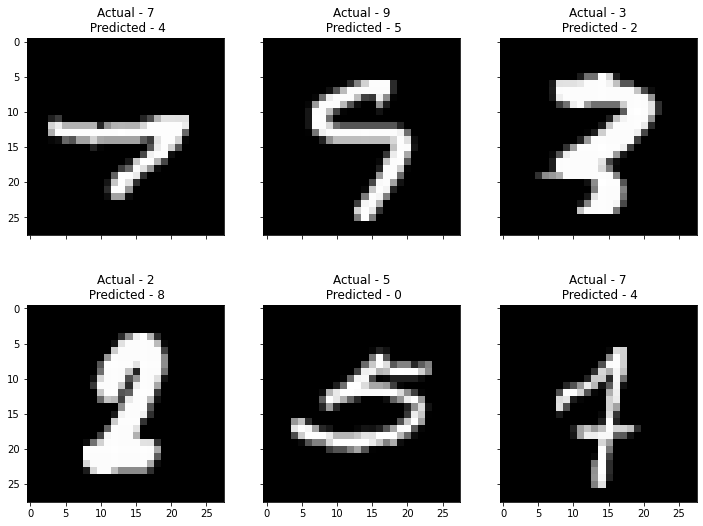

In [16]:
plot_misclassified(islr_oof)

## Model 2: 4-Layer Neural Network

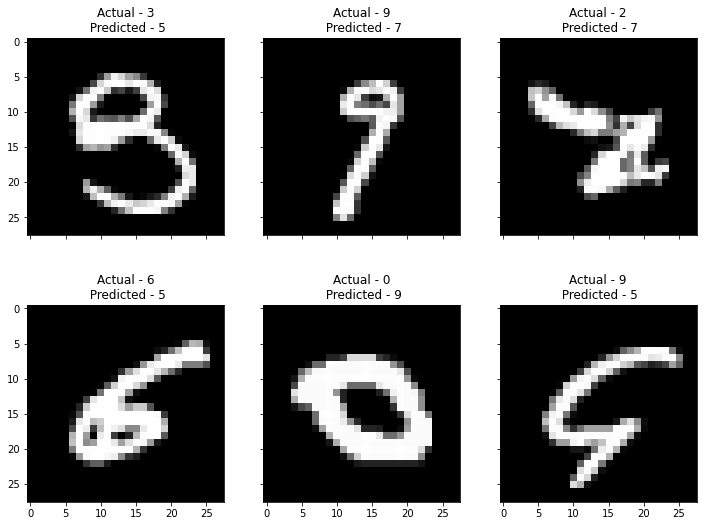

In [17]:
plot_misclassified(ebook_oof)

## Model 3: Convolutional Neural Network

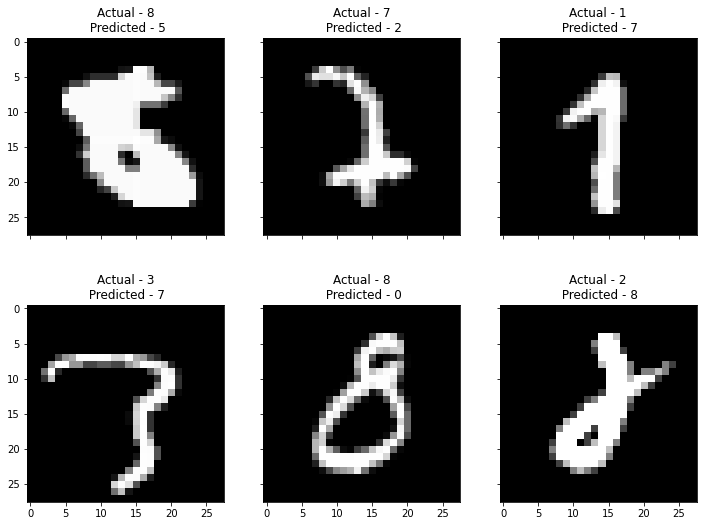

In [18]:
plot_misclassified(ebook_cnn_oof)

## Model 4: Convolutional Neural Network with Dropout

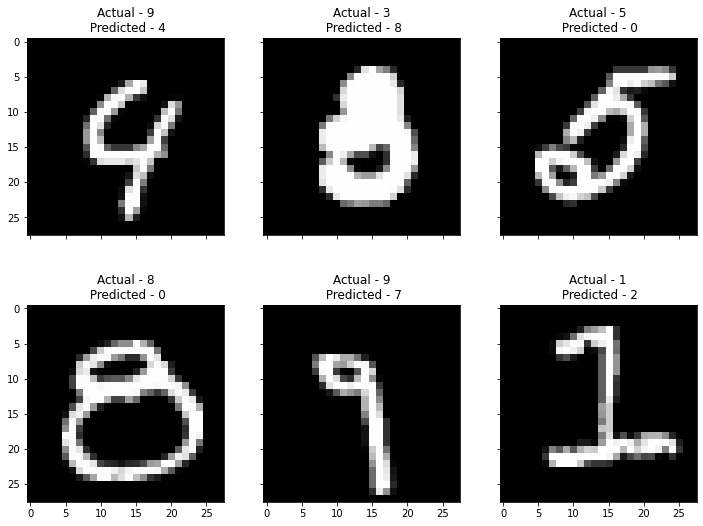

In [19]:
plot_misclassified(keras_oof)